# Random Forest (an extension on the Decision Tree Class)

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda, Inc.| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3


In [2]:
import sys 
sys.path.append('../modules')
from decision_tree_classifier import decision_tree_classifier
import collections
import pandas as pd
import numpy as np

class random_forest_classifier:
    
    def __init__(self, n_trees = 10, max_depth=None, n_features='sqrt', mode='rfnode', seed=None):
        """
        Random Forest Classifier uses bootstrapping and column randomization
        to generate n_trees different datasets and then applies a decision 
        tree to each dataset. The final prediction is an ensemble of all created trees.
        ---
        Params:
        n_trees (int): number of bootstrapped trees to grow for ensembling
        max_depth (int): maximum number of splits to make in each tree)
        n_features: The number of columns to include in the models. 
                    Options: numeric value (e.g. 4 => 4 columns used)
                             "sqrt" (square root of the number of cols in input data)
                             "div3" (number of input cols divided by 3)
        mode: If mode='rfnode' the column randomization happens at each node. Otherwise
              Each tree gets one randomized set of columns for all nodes in that tree.
        seed: Random seed to allow for reproducibility.
        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.n_features = n_features
        self.tree_filter_pairs = []
        self.mode = mode
        if seed:
            self._seed = seed
            np.random.seed(seed)
        
    def find_number_of_columns(self, X):
        """
        Uses the user input for n_features to decide how many columns should
        be included in each model. Uses the shape of X to decide the final number
        if 'sqrt' is called. 
        ---
        Input: X (array, dataframe, or series)
        """
        if isinstance(self.n_features, int):
            return self.n_features
        if self.n_features == 'sqrt':
            return int(np.sqrt(X.shape[1])+0.5)
        if self.n_features == 'div3':
            return int(X.shape[1]/3+0.5)
        else:
            raise ValueError("Invalid n_features selection")
    
    def get_bagged_data(self, X, y):
        """
        Chooses random rows to populate a bootstrapped dataset, with replacement.
        Maintains the correlation between X and y
        ---
        Input: X, y (arrays)
        Outputs: randomized X,y (arrays)
        """
        index = np.random.choice(np.arange(len(X)),len(X))
        return X[index], y[index]
    
    def randomize_columns(self,X):
        """
        Chooses a set of columns to keep from the input data. These are
        randomly drawn, according the number requested by the user. The data
        is filtered and only the allowed columns are returned, along with the
        filter. 
        ---
        Input: X (array)
        Output: filtered_X (array), filter (array)
        """
        num_col = self.find_number_of_columns(X)
        filt = np.random.choice(np.arange(0,X.shape[1]),num_col,replace=False)
        filtered_X = self.apply_filter(X, filt)
        return filtered_X, filt
    
    def apply_filter(self, X, filt):
        """
        Given X and a filter, only the columns matching the index values
        in filter are returned.
        ---
        Input: X (array), filter (array of column IDs)
        Output: filtered_X (array)
        """
        filtered_X = X.T[filt]
        return filtered_X.T
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)
    
    def fit(self, X, y):
        """
        Generates the bootstrapped data, decides which column to keep,
        and then uses the decision tree class to build a model on each 
        bootstrapped and column-randomized dataset. Each tree is stored 
        as part of the model for later use, along with the appropriate
        filter - which is needed to filter new data for use with the model.
        ---
        Input: X, y (arrays, dataframe, or series)
        """
        X = self.pandas_to_numpy(X)
        y = self.pandas_to_numpy(y)
        try:
            self.base_filt = [x for x in range(X.shape[1])]
        except IndexError:
            self.base_filt = [0]
        for _ in range(self.n_trees):
            filt = self.base_filt
            bagX, bagy = self.get_bagged_data(X,y)
            if self.mode == 'rftree':
                bagX, filt = self.randomize_columns(bagX)
            new_tree = decision_tree_classifier(self.max_depth, mode=self.mode, n_features=self.n_features)
            new_tree.fit(bagX, bagy)
            self.tree_filter_pairs.append((new_tree, filt))
    
    def predict(self, X):
        """
        Uses the list of tree models built in the fit, doing a predict with each
        model. The associated filter is applied to X, so the model sees the columns
        it has learned about. The final prediction uses the mode of all the trees 
        predictions.
        ---
        Input: X (array, dataframe, or series)
        Output: Class ID (int)
        """
        X = self.pandas_to_numpy(X)
        self.predicts = []
        for tree, filt in self.tree_filter_pairs:
            filtered_X = self.apply_filter(X, filt)
            self.predicts.append(tree.predict(filtered_X))
        self.pred_by_row = np.array(self.predicts).T
        
        ensemble_predict = []
        for row in self.pred_by_row:
            ensemble_predict.append(collections.Counter(row).most_common(1)[0][0])
        return ensemble_predict
    
    def score(self, X, y):
        """
        Uses the predict method to measure the accuracy of the model.
        ---
        In: X (list or array), feature matrix; y (list or array) labels
        Out: accuracy (float)
        """
        pred = self.predict(X)
        correct = 0
        for i,j in zip(y,pred):
            if i == j:
                correct+=1
        return float(correct)/float(len(y))

# Let's try it out with the Iris dataset

In [3]:
def get_data():
    from sklearn.datasets import load_iris
    iris = load_iris()
    return iris.data, iris.target

In [4]:
X,y = get_data()

In [5]:
from data_splitting import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [6]:
rf = random_forest_classifier(n_trees=25, n_features='sqrt', mode='rfnode', seed=42)
rf.fit(X_train, y_train)

In [7]:
preds = rf.predict(X_test)
for i,j in zip(preds[10:40:2], rf.pred_by_row[10:40:2]):
    print(j,i)

[1 0 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 0 2 0 1 2] 1
[1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 1
[1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1] 1
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 1
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 2
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 2
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 2
[1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 1 2 1 2 1 2 2] 2
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 2
[1 1 2 1 1 1 2 1 2 2 1 2 2 1 1 1 2 2 1 2 1 1 1 2 1] 1


Make sure each node is getting randomized properly in rfnode mode.

In [29]:
for tr in rf.tree_filter_pairs:
    print(tr[0].tree.filt)
        

[1 2]
[3 0]
[2 3]
[3 2]
[1 3]
[0 2]
[2 3]
[0 3]
[0 1]
[0 3]
[3 2]
[2 3]
[3 0]
[2 3]
[3 2]
[0 2]
[1 2]
[1 0]
[2 0]
[1 3]
[0 2]
[0 1]
[0 2]
[3 0]
[0 2]


In [9]:
rf.score(X_test,y_test)

1.0

In [53]:
accs = []
for n in range(1,100,5):
    rf = random_forest_classifier(n_trees=n, mode='rfnode')
    rf.fit(X_train, y_train)
    accs.append(rf.score(X_test, y_test))

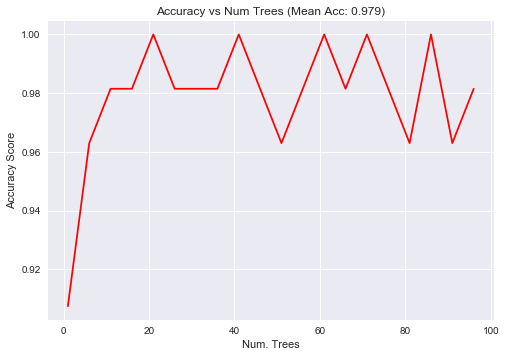

In [54]:
plt.plot(range(1,100,5),accs,'r')
plt.xlabel("Num. Trees")
plt.ylabel("Accuracy Score")
plt.title("Accuracy vs Num Trees (Mean Acc: %.3f)"%round(np.mean(accs),3));

# Now let's play with some more complicated data

In [55]:
from sklearn.datasets import load_wine
X = load_wine().data
y = load_wine().target

In [56]:
from data_splitting import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [57]:
rf = random_forest_classifier(n_trees=10, mode='rfnode')
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9482758620689655

In [58]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_test, y_test)

0.29310344827586204

In [59]:
accs = []
for n in range(1,100,5):
    rf = random_forest_classifier(n_trees=n, mode='rfnode', seed=42)
    rf.fit(X_train, y_train)
    accs.append(rf.score(X_test, y_test))

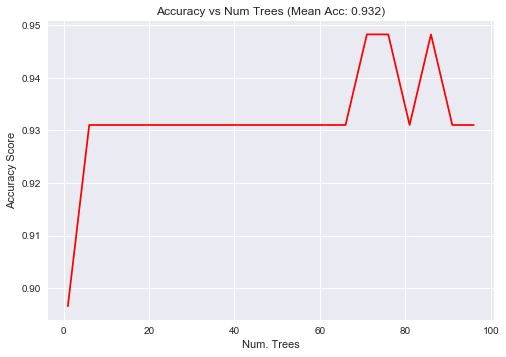

In [60]:
plt.plot(range(1,100,5),accs,'r')
plt.xlabel("Num. Trees")
plt.ylabel("Accuracy Score")
plt.title("Accuracy vs Num Trees (Mean Acc: %.3f)"%round(np.mean(accs),3));

# Now let's look at a few trees to see whether they're all being built the same way.

In [61]:
X,y = get_data()
from data_splitting import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [62]:
rf = random_forest_classifier(n_trees=5, n_features='sqrt', mode='rfnode')
rf.fit(X_train, y_train)

In [63]:
for i, tree in enumerate(rf.tree_filter_pairs):
    print("--- Tree %i ---"%i,"\n")
    tree[0].print_tree()
    print("\n\n")

--- Tree 0 --- 

Column 3 : 1.8? 
--- True:  Column 2 : 5.0? 
------ True:  {2: 35}
------ False:  {1: 1}
--- False:  Column 3 : 1.0? 
------ True:  Column 0 : 6.3? 
--------- True:  Column 2 : 5.1? 
------------ True:  {2: 2}
------------ False:  {1: 12}
--------- False:  {1: 23}
------ False:  {0: 27}



--- Tree 1 --- 

Column 3 : 0.4? 
--- True:  Column 2 : 5.3? 
------ True:  {2: 21}
------ False:  Column 0 : 5.5? 
--------- True:  Column 3 : 1.8? 
------------ True:  Column 2 : 4.9? 
--------------- True:  {2: 5}
--------------- False:  Column 1 : 3.2? 
------------------ True:  {1: 1}
------------------ False:  {2: 1}
------------ False:  Column 1 : 2.8? 
--------------- True:  Column 2 : 5.1? 
------------------ True:  {2: 2}
------------------ False:  Column 3 : 1.3? 
--------------------- True:  {1: 19}
--------------------- False:  {0: 1}
--------------- False:  {1: 16}
--------- False:  Column 2 : 3.3? 
------------ True:  Column 0 : 5.0? 
--------------- True:  {1: 2}
----